# Goal of this notebook

This Notebook loads the stratified Data on Transport groups (**from sample_istdaten.ipynb**), and uses it to determine which categories (on transport and time) should we group on.

# Init spark

In [1]:
%%local
import os
username = os.environ['JUPYTERHUB_USER']

# set the application name as "<your_gaspar_id>-homework3"
get_ipython().run_cell_magic('configure', line="-f", cell='{ "name":"%s-finalproject3", "executorMemory":"4G", "executorCores":4, "numExecutors":10, "driverMemory": "4G" }' % username)

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6242,application_1618324153128_5732,pyspark,idle,Link,Link,None,
6319,application_1618324153128_5831,pyspark,idle,Link,Link,None,
6323,application_1618324153128_5835,pyspark,idle,Link,Link,None,
6337,application_1618324153128_5850,pyspark,idle,Link,Link,None,
6341,application_1618324153128_5855,pyspark,idle,Link,Link,None,
6345,application_1618324153128_5859,pyspark,idle,Link,Link,None,
6347,application_1618324153128_5862,pyspark,idle,Link,Link,None,
6351,application_1618324153128_5866,pyspark,idle,Link,Link,None,
6357,application_1618324153128_5873,pyspark,idle,Link,Link,None,
6358,application_1618324153128_5874,pyspark,idle,Link,Link,None,


In [ ]:
%%send_to_spark -i username -t str -n username

Starting Spark application


In [ ]:
print('We are using Spark %s' % spark.version)

In [ ]:
spark.sparkContext.addPyFile('hdfs:///user/boesinge/finalproject/data_utils.py')

## Imports

In [5]:
import data_utils
import datetime
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from scipy.stats import gamma, zscore

from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.window import Window

from functools import reduce
from pyspark.sql import DataFrame

import matplotlib
matplotlib.use('agg')
import matplotlib.pylab as plt

from pandas.compat import StringIO
pd.set_option('display.max_columns', 500)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Stratified Istdaten

In [6]:
istdaten_df = sqlContext.read.load('/user/boesinge/finalproject/istdaten_transport_group.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
istdaten_df.groupby('transport_group').count().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+-----+
|transport_group|count|
+---------------+-----+
|             IC|99147|
|              E|99728|
|              T|99857|
|              B|99972|
|             IR|99837|
|              S|99600|
|              R|99962|
|            EXT| 6289|
+---------------+-----+

### Computing arrival/departure time from isdaten

In [8]:
def compute_arrival_departure(df):
    with_id = df.withColumn("id", monotonically_increasing_id())

    w = Window().partitionBy(['trip_id', 'trip_date']).orderBy('scheduled_departure_time')

    # Use window to group (departure, arrival) tuples together (sliding)
    grouped = with_id\
         .withColumn('rank', F.rank().over(w))\
         .withColumn('start', F.lag("stop_id").over(w))\
         .withColumn('scheduled_departure_time', F.lag("scheduled_departure_time").over(w))\
         .withColumnRenamed('stop_id','end')\
         .select('start','scheduled_departure_time','scheduled_arrival_time','actual_arrival_time', 'end','transport_group','line_id')\
         .dropna()

    # drop out un wanted loops ((A->B) (B->C) (C->A)) 
    grouped =  grouped.filter(F.abs(grouped.scheduled_departure_time -grouped.scheduled_arrival_time) < 60*60*2 )
    return grouped

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Computing delays 

In [12]:
non_zero = F.udf(lambda x : x if x > 0 else 0, T.IntegerType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
delays = data_utils.compute_delays(data_utils.compute_arrival_departure(istdaten_df))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Creating time categories

In this section, we compute the mean delay per hour, in order to determine which time periods should be grouped together.

First we compute the average using pyspark :

In [14]:
delay_by_timestamp = delays.withColumn('hour', F.hour(F.from_unixtime('scheduled_arrival_time'))).groupby('hour').agg(F.mean(non_zero('arrival_delay')).alias('mean_delay')).toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Then we can plot using pandas and plt

In [15]:
plt.figure()
delay_by_timestamp.sort_values(by='hour')['mean_delay'].plot(kind='bar')
plt.gca().set(xticklabels=range(24))
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

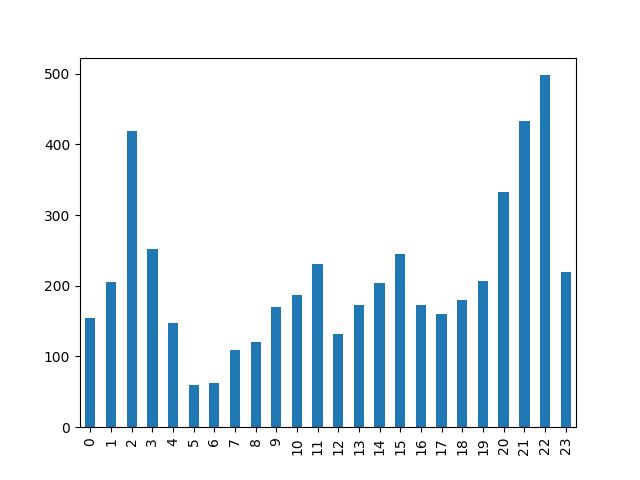

In [16]:
%matplot plt

This makes us think that we should probably select the following time categories : 

- Nighttime spike [0-3]
- Normal zone [4-6]
- Morning-Noon spike [7-14]
- Afternoon spike [15-18]
- Evening [19-23]

This gives a graph which looks more like :

In [31]:
plt.figure()

color_range = ['b' if x in range(0,4)
               else 'r' if x in range (4,7)
               else 'g' if x in range(7,15)
               else 'y' if x in range(15,19)
               else 'k' for x in range(24)]

delay_by_timestamp.sort_values(by='hour')['mean_delay'].plot(kind='bar', color=color_range)
plt.gca().set(xticklabels=range(24))
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

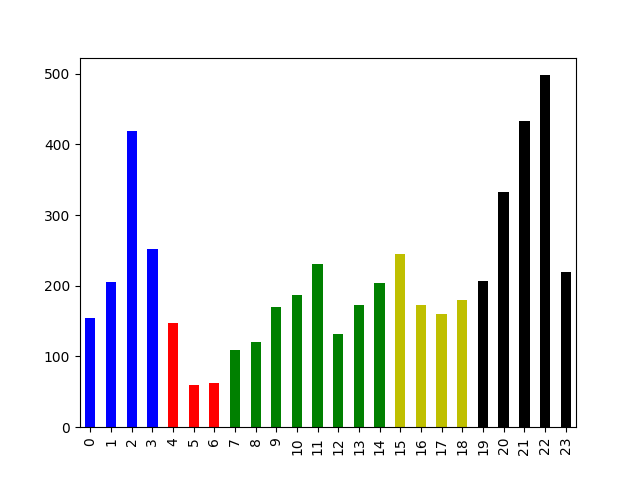

In [32]:
%matplot plt

## Studying transport category
Let's simply plot the average delay per transport categories

In [ ]:
delay_by_transport = delays.groupby('transport_group').agg(F.mean(non_zero('arrival_delay').alias('mean_delay'))\
                                                            ,F.std(non_zero('arrival_delay').alias('std_delay'))\
                                                           .toPandas()


In [ ]:
delay_by_transport.plot(kind = "dist",yerr ="std_delay")

In [ ]:
%matplot plt

The above figure supports the fact that we need to incorporate the transport type in the delay modeling. 
